In [1]:
from libemg.datasets import OneSubjectMyoDataset
from libemg.emg_predictor import EMGClassifier
from libemg.feature_extractor import FeatureExtractor
from libemg.offline_metrics import OfflineMetrics
import matplotlib.pyplot as plt


/Users/sero/miniconda3/envs/neuromotor/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
## Set up constants
WINDOW_SIZE = 20
WINDOW_INCREMENT = 10
FEATURE_SET = "HTD"


In [13]:
## Load dataset
# Load in dataset
dataset = OneSubjectMyoDataset()
data = dataset.prepare_data()

# Split data into training and testing
train_data = data['Train'] 
test_data = data['Test'] 

# Extract windows 
train_windows, train_meta = train_data.parse_windows(WINDOW_SIZE, WINDOW_INCREMENT)
test_windows, test_meta = test_data.parse_windows(WINDOW_SIZE, WINDOW_INCREMENT)

fe = FeatureExtractor()
om = OfflineMetrics()

classifiers = ["LDA","SVM","KNN","RF","QDA"]


60 data files fetched out of 61 files.


In [12]:
train_windows

array([[[  1.,  -4.,   5., ...,  -2.,   1.,  -7.],
        [ -5.,  -4.,   5., ...,   1.,  -1.,  -6.],
        [  0.,  12.,   0., ...,   2.,   3.,  -1.],
        ...,
        [  1.,  -4.,  -5., ...,   2.,  -1.,  -1.],
        [ -1.,  -2.,  -4., ...,  -1.,   0.,  -1.],
        [ -1.,  -2.,  -3., ...,  -3.,   4.,  -2.]],

       [[  1.,  -3.,   0., ...,   5., -19.,  -7.],
        [ -2.,  -2.,   1., ...,   0.,  -8.,  -4.],
        [-10., -13.,  -1., ...,  -3.,   4.,  -1.],
        ...,
        [ -1.,  -5.,   5., ...,   2.,  -5.,  -5.],
        [ -2.,   0.,   0., ...,   0.,  -1.,  -8.],
        [  1.,   0.,   0., ...,   0.,  -1.,  -4.]],

       [[ -9.,  -5.,  -6., ...,  10.,  22., -40.],
        [  3.,  -7.,   0., ...,   0.,   3.,  -9.],
        [  0.,  -3.,  -1., ...,  -5.,   8.,  -6.],
        ...,
        [ -1.,  -3.,  -1., ...,  -2.,   1.,  -1.],
        [ -3.,  -3.,  -1., ...,   0.,   1.,  -1.],
        [ -1.,  -3.,  -3., ...,   0.,   1.,  -8.]],

       ...,

       [[-10.,   5.,  -1

In [14]:
## Feature extraction
# Create data set dictionary using training data
data_set = {}
data_set['training_features'] = fe.extract_feature_group(FEATURE_SET, train_windows)
data_set['training_labels'] = train_meta['classes']

test_features = fe.extract_feature_group(FEATURE_SET, test_windows)

cas = []
aers = []
inss = []


In [15]:
# Extract metrics for each classifier
for classifier in classifiers:
    model = EMGClassifier(classifier)

    # Fit and run the classifier
    model.fit(data_set.copy())
    preds, probs = model.run(test_features)

    # Null label is 2 since it is the no movement class
    metrics = om.extract_common_metrics(test_meta["classes"], preds, 2)
    cas.append(metrics["CA"] * 100)
    aers.append(metrics["AER"] * 100)
    inss.append(metrics["INS"] * 100)


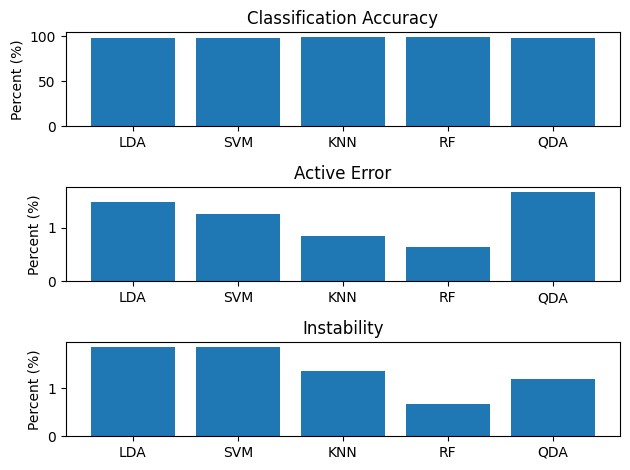

In [17]:
# Plot offline metrics
fig, axs = plt.subplots(3)
axs[0].bar(classifiers, cas)
axs[0].set_title("Classification Accuracy")
axs[0].set_ylabel("Percent (%)")
axs[1].bar(classifiers, aers)
axs[1].set_title("Active Error")
axs[1].set_ylabel("Percent (%)")
axs[2].bar(classifiers, inss)
axs[2].set_title("Instability")
axs[2].set_ylabel("Percent (%)")
plt.tight_layout()
plt.show()

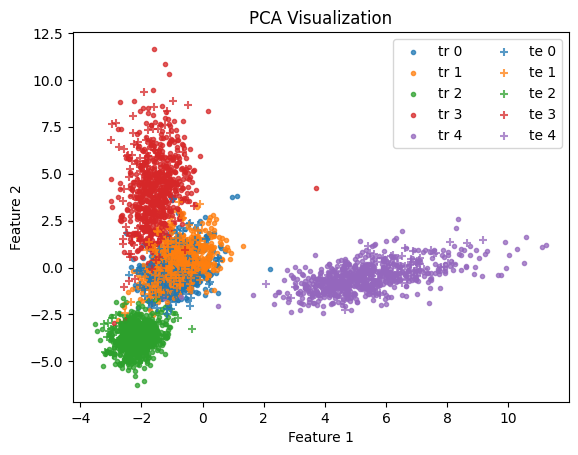

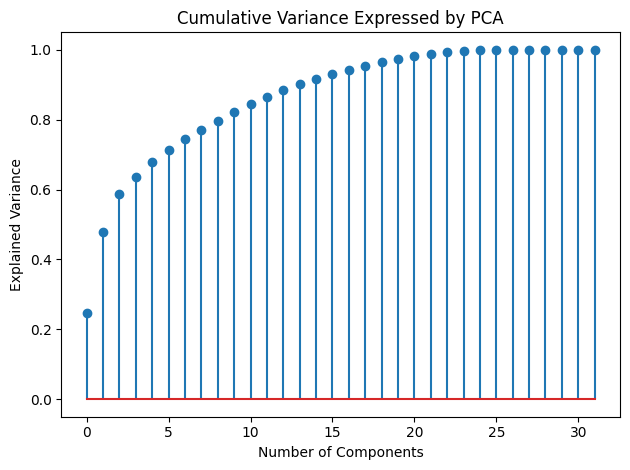

In [18]:
# Plot feature space 
fe.visualize_feature_space(data_set['training_features'], projection="PCA", classes=train_meta['classes'], test_feature_dic=test_features, t_classes=test_meta['classes'])